### Prediciton of Tm values

Tm = melting Temperature

Melting Temperature is the Temperature at which half of the protein is in the unfolded state, this parameter belongs to the thermodynamic stability.

1. We used the machine learning ProTstab2 prediction model as a web service (http://8.133.174.28:8000/ProTstab2/)
    - For this purpose, the sequences to be predicted need to be formatted and saved as a Fasta file.
    - Since only a specific number of sequences can be predicted per prediction round, the Fasta file containing the sequences for prediction is split into multiple files.
2. The predicted Tm values are outputted as PDFs, which are sent via email.
3. The PDFs are parsed, and the extracted information is stored in a dataframe and the dataframe is merged with the dataframe that contains both the DMS score for further analysis.

Important Note: We wanted to measure the protein stability using another parameter. However, the prediction based on the limitations of the prediction model did not work; too many Tm values of the mutants could not be predicted.

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr

In [72]:
df_GFP_unaltered = pd.read_csv('/mnt/c/Users/uni.rebecca.ress/Documents/rebecca.ress/Universität Heidelberg/4. Fachsemester/4. Fachsemester/Bioinformatik Projekt Niopek/Daten/GFP_AEQVI_Sarkisyan_2016.csv')

df_GFP_single = df_GFP_unaltered[~df_GFP_unaltered['mutant'].str.contains(':')]
df_GFP_single_split = df_GFP_single.copy()
df_GFP_single_split[['old AA', 'Position', 'new AA']] = df_GFP_single['mutant'].str.extract(r'(\w)(\d+)(\w)')

print(df_GFP_single_split)

      mutant                                   mutated_sequence  DMS_score  \
4        K3R  MSRGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...   3.738586   
48       K3Q  MSQGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...   3.750487   
703      K3E  MSEGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...   3.666278   
924      K3M  MSMGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...   3.698336   
1160     K3T  MSTGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...   3.629775   
...      ...                                                ...        ...   
51709  Y237N  MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...   3.809468   
51710  Y237C  MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...   3.760217   
51711  Y237D  MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...   3.754101   
51712  Y237F  MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...   3.673173   
51713  Y237H  MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...   3.735417   

       DMS_score_bin old AA Position new AA  
4                

In [73]:
#sequences need to be formatted and saved as a Fasta file for the prediction
def dataframe_to_fasta(df, fasta_file):
    with open(fasta_file, 'w') as file:
        for index, row in df.iterrows():
            header = f">|P42212_{index}| Uncharacterized protein\n"
            sequence = f"{row['mutated_sequence']}\n"
            file.write(header + sequence)

df_GFP_single_split

fasta_file = 'Tm_single.fasta'
dataframe_to_fasta(df_GFP_single_split, fasta_file)

with open(fasta_file, 'r') as file:
    fasta_content = file.read()

print(fasta_content)

>|P42212_4| Uncharacterized protein
MSRGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK
>|P42212_48| Uncharacterized protein
MSQGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK
>|P42212_703| Uncharacterized protein
MSEGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK
>|P42212_924| Uncharacterized protein
MSMGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDG

In [74]:
#Fasta file containing the sequences for prediction is split into multiple files.
def split_fasta_file(fasta_file, output_prefix, num_parts):
    with open(fasta_file, 'r') as file:
        fasta_content = file.read()

    num_sequences = fasta_content.count('>')
    sequences_per_part = num_sequences // num_parts
    # create new documents with sequences
    sequence_counter = 0
    part_counter = 1
    current_part_sequences = []
    for line in fasta_content.split('\n'):
        if line.startswith('>'):
            if sequence_counter > 0 and sequence_counter % sequences_per_part == 0:
                output_file = f'{output_prefix}_{part_counter}.fasta'
                with open(output_file, 'w') as outfile:
                    outfile.write('\n'.join(current_part_sequences))
                print(f'create: {output_file}')
                current_part_sequences = []
                part_counter += 1
            current_part_sequences.append(line)
            sequence_counter += 1
        else:
            current_part_sequences.append(line)

    # last document
    if current_part_sequences:
        output_file = f'{output_prefix}_{part_counter}.fasta'
        with open(output_file, 'w') as outfile:
            outfile.write('\n'.join(current_part_sequences))
        print(f'create: {output_file}')

fasta_file = 'Tm_single.fasta'
output_prefix = 'Tm_single'
num_parts = 10

split_fasta_file(fasta_file, output_prefix, num_parts)

create: Tm_single_1.fasta
create: Tm_single_2.fasta
create: Tm_single_3.fasta
create: Tm_single_4.fasta
create: Tm_single_5.fasta
create: Tm_single_6.fasta
create: Tm_single_7.fasta
create: Tm_single_8.fasta
create: Tm_single_9.fasta
create: Tm_single_10.fasta
create: Tm_single_11.fasta


In [75]:
pip install --upgrade PyPDF2

Note: you may need to restart the kernel to use updated packages.


In [76]:
import PyPDF2
import re
import os

folder_path = r'/mnt/c/Users/uni.rebecca.ress/Documents/rebecca.ress/Universität Heidelberg/4. Fachsemester/4. Fachsemester/Bioinformatik Projekt Niopek/Daten/PDF_files_Tm_prediciton_single'

# create a list for collected data
data_Tm = []

# Go through all files in the folder
for filename in os.listdir(folder_path):
    # Only consider PDF Files
    if filename.endswith(".pdf"):
        # open PDF doc
        file_path = os.path.join(folder_path, filename)
        with open(file_path, "rb") as file:
            reader = PyPDF2.PdfReader(file)

            # extract the data from each page
            for page in reader.pages:
                text = page.extract_text()
                 #extract protein name and prediciton result
                name_matches = re.findall(r"P42212_(\d+)", text)  #Extracts the protein name in the format "P42212_" + number
                prediction_matches = re.findall(r"(?:0\.000|\d+\.\d+)", text)  # Extracts numbers in the format "0.000" or "123.456".

                for name, prediction in zip(name_matches, prediction_matches):
                    protein_name = "P42212_" + name
                    data_Tm.append({"Protein name": protein_name, "Tm value": prediction.strip()})

df_predicted_Tm_values_single = pd.DataFrame(data_Tm)
print(df_predicted_Tm_values_single)

      Protein name Tm value
0         P42212_4   49.374
1        P42212_48   49.303
2       P42212_703   49.290
3       P42212_924   49.295
4      P42212_1160   49.324
...            ...      ...
1079  P42212_50897   49.105
1080  P42212_50900   48.974
1081  P42212_50908   49.284
1082  P42212_50913   49.253
1083  P42212_50918   49.328

[1084 rows x 2 columns]


In [82]:
#merging the two dataframes; new name for new dataframe

df_predicted_Tm_values_single_number = df_predicted_Tm_values_single.copy()
df_predicted_Tm_values_single_number['number'] = df_predicted_Tm_values_single_number['Protein name'].str.split('_').str[1]

df_GFP_single_split_number = df_GFP_single_split.copy()
df_GFP_single_split_number['number'] = df_GFP_single_split.index

df_GFP_single_split_number['number'] = df_GFP_single_split_number['number'].astype(int)
df_predicted_Tm_values_single_number['number'] = df_predicted_Tm_values_single_number['number'].astype(int)

merged_df = df_GFP_single_split_number.merge(df_predicted_Tm_values_single_number, on='number')

df_Tm_DMS_score_split = merged_df[['mutant', 'old AA', 'Position', 'new AA', 'DMS_score', 'Tm value']].copy()
print(df_Tm_DMS_score_split)


     mutant old AA Position new AA  DMS_score Tm value
0       K3R      K        3      R   3.738586   49.374
1       K3Q      K        3      Q   3.750487   49.303
2       K3E      K        3      E   3.666278   49.290
3       K3M      K        3      M   3.698336   49.295
4       K3T      K        3      T   3.629775   49.324
...     ...    ...      ...    ...        ...      ...
1079  Y237N      Y      237      N   3.809468   49.001
1080  Y237C      Y      237      C   3.760217    0.000
1081  Y237D      Y      237      D   3.754101    0.000
1082  Y237F      Y      237      F   3.673173    0.000
1083  Y237H      Y      237      H   3.735417    0.000

[1084 rows x 6 columns]


In [83]:
# Convert the column "Tm" to floating-point numbers
df_Tm_DMS_score_split["Tm value"] = df_Tm_DMS_score_split["Tm value"].astype(float)

# Find the minimum Tm value that is not equal to 0.000
min_tm_non_zero = df_Tm_DMS_score_split.loc[df_Tm_DMS_score_split["Tm value"] != 0.000, "Tm value"].min()

# Find the maximum Tm value
max_tm = df_Tm_DMS_score_split["Tm value"].max()

# Count the number of 0.000 values in Tm
count_zeros = (df_Tm_DMS_score_split["Tm value"] == 0.000).sum()

# Print the results
print("Min Tm (non-zero):", min_tm_non_zero)
print("Max Tm:", max_tm)
print("Number of 0.000 values in Tm:", count_zeros)


Min Tm (non-zero): 48.113
Max Tm: 68.636
Number of 0.000 values in Tm: 428


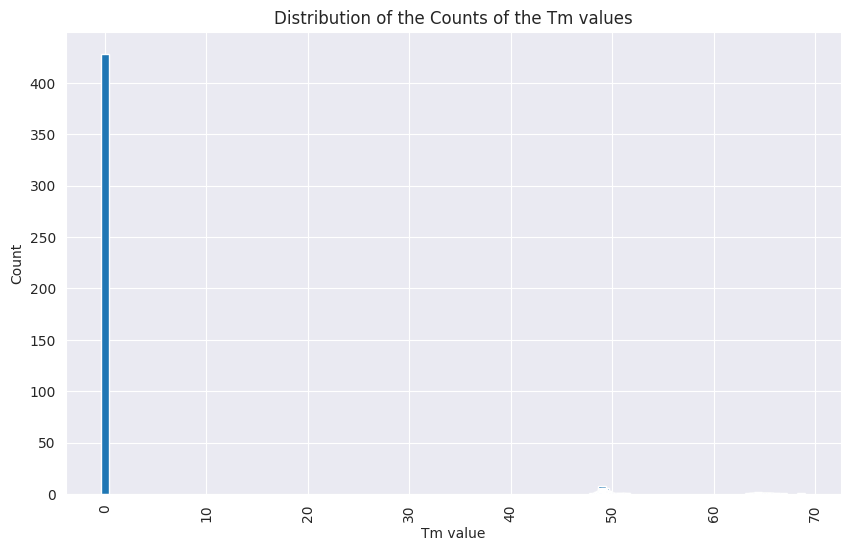

In [84]:
# Count Tm values
tm_counts = df_Tm_DMS_score_split["Tm value"].value_counts()

# Extract data for the plot
tm_values = tm_counts.index
count_values = tm_counts.values

# Create the plot
plt.figure(figsize=(10, 6))
plt.bar(tm_values, count_values)
plt.xlabel("Tm value")
plt.ylabel("Count")
plt.title("Distribution of the Counts of the Tm values")
plt.xticks(rotation=90)
plt.show()


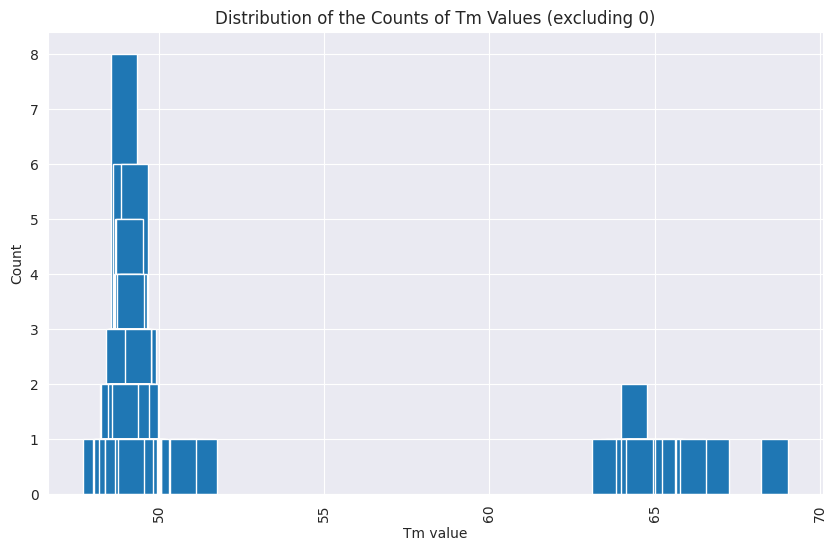

In [85]:
# Count Tm values excluding 0
tm_counts = df_Tm_DMS_score_split["Tm value"].loc[df_Tm_DMS_score_split["Tm value"] != 0.000].value_counts()

# Extract data for the plot
tm_values = tm_counts.index
count_values = tm_counts.values

plt.figure(figsize=(10, 6))
plt.bar(tm_values, count_values)
plt.xlabel("Tm value")
plt.ylabel("Count")
plt.title("Distribution of the Counts of Tm Values (excluding 0)")
plt.xticks(rotation=90)
plt.show()


In [86]:
# Tm value of the Wild type predicted by the ProTstab2
data = {
    "Protein Name": ["P42212"],
    "Tm": [49.190]
}
avGFP_WT_TM_single = pd.DataFrame(data)

In [87]:
#counts of Tm values < than the value of the WT (excluding the 0.00)

df_Tm_DMS_score_split["Tmv value"] = df_Tm_DMS_score_split["Tm value"].astype(float)

count = len(df_Tm_DMS_score_split[(df_Tm_DMS_score_split["Tm value"] < 49.190) & (df_Tm_DMS_score_split["Tm value"] != 0)])
print(count)

380


In [88]:
#counts of Tm values > than the Wild type value
df_Tm_DMS_score_split["Tm value"] = df_Tm_DMS_score_split["Tm value"].astype(float)

count = len(df_Tm_DMS_score_split[df_Tm_DMS_score_split["Tm value"] > 49.190])
print(count)

276


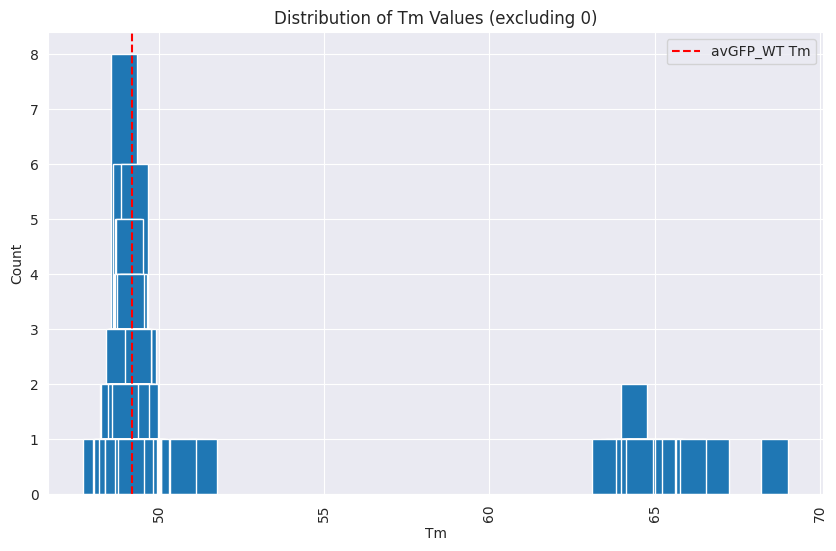

In [89]:
# Count Tm values excluding 0
tm_counts = df_Tm_DMS_score_split["Tm value"].loc[df_Tm_DMS_score_split["Tm value"] != 0.000].value_counts()

# Extract data for the plot
tm_values = tm_counts.index
count_values = tm_counts.values

# Create the plot
plt.figure(figsize=(10, 6))
plt.bar(tm_values, count_values)
plt.axvline(x=49.190, color='red', linestyle='--', label='avGFP_WT Tm')
plt.xlabel("Tm")
plt.ylabel("Count")
plt.title("Distribution of Tm Values (excluding 0)")
plt.xticks(rotation=90)
plt.legend()
plt.show()


spearman correlation coefficient (All values): 0.034861894069716744
p-value (All values): 0.25145488851417486


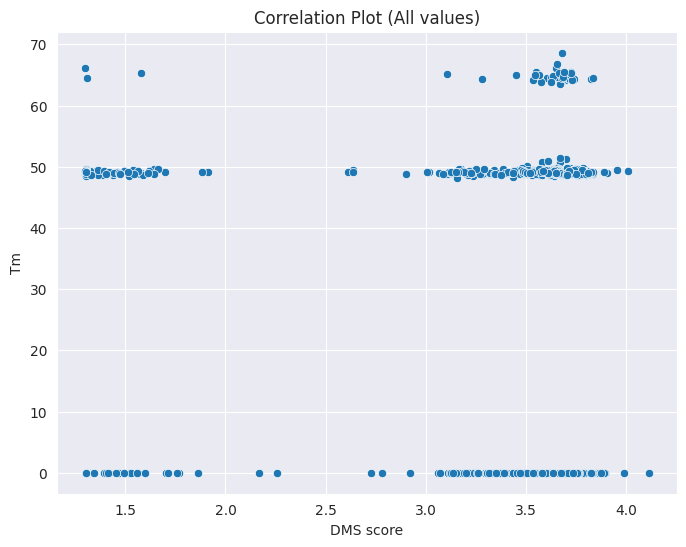

spearman correlation coefficient (Without Tm values of 0): 0.034861894069716744
p-value (Without Tm values of 0): 0.25145488851417486


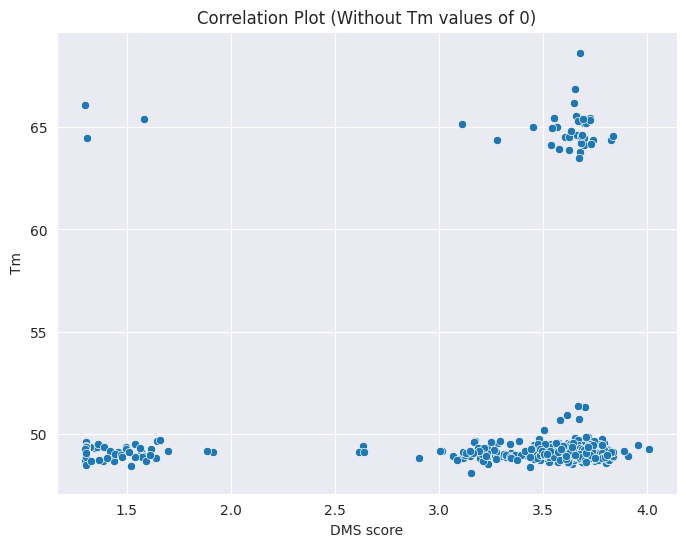

In [90]:
# Correlation Analysis and Plots

# Correlation analysis with all values
corr_all, p_value_all = spearmanr(df_Tm_DMS_score_split["DMS_score"], df_Tm_DMS_score_split["Tm value"])
print("spearman correlation coefficient (All values):", corr_all)
print("p-value (All values):", p_value_all)

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_Tm_DMS_score_split, x="DMS_score", y="Tm value")
plt.title("Correlation Plot (All values)")
plt.xlabel("DMS score")
plt.ylabel("Tm")
plt.show()

# Correlation analysis without Tm values of 0
df_filtered = df_Tm_DMS_score_split.loc[df_Tm_DMS_score_split["Tm value"] != 0.000]
corr_filtered, p_value_filtered = spearmanr(df_Tm_DMS_score_split["DMS_score"], df_Tm_DMS_score_split["Tm value"])
print("spearman correlation coefficient (Without Tm values of 0):", corr_filtered)
print("p-value (Without Tm values of 0):", p_value_filtered)

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_filtered, x="DMS_score", y="Tm value")
plt.title("Correlation Plot (Without Tm values of 0)")
plt.xlabel("DMS score")
plt.ylabel("Tm")
plt.show()


Due to the high number of Tm values that could not be predicted by the forecasting model, even after multiple attempts and modifications of the process, no further analyses will be conducted.